In [39]:
import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
from scikit_posthocs import posthoc_dunn
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import numpy as np

In [4]:
# Cargar el archivo Excel
df = pd.read_excel("Metricas.xlsx")

# Mostrar las primeras filas para verificar
print("📊 Datos cargados correctamente. Vista previa:")
display(df.head())

📊 Datos cargados correctamente. Vista previa:


,nombre,tipo,con_json,accuracy,precision,recall,f1
0,cogito,CoT,1,0.60,0.81,0.64,0.67
1,granite3.3,CoT,1,0.71,0.73,0.79,0.74
2,llama3.2,Base,1,0.71,0.93,0.73,0.80
3,mistral,Base,1,0.69,0.96,0.67,0.76
4,phi3.5,Base,1,0.67,0.81,0.68,0.71


In [14]:
# 1. Análisis CON JSON (con_json=1)  
df_json = df[df['con_json'] == 1]  
moe_json = df_json[df_json['tipo'] == 'MoE']['recall']  
cot_json = df_json[df_json['tipo'] == 'CoT']['recall']  
base_json = df_json[df_json['tipo'] == 'Base']['recall']  

H_json, p_json = kruskal(moe_json, cot_json, base_json)  
print(f"CON JSON: H={H_json:.2f}, p={p_json:.4f}")  

CON JSON: H=3.52, p=0.1722


In [15]:
# 2. Análisis SIN JSON (con_json=0)  
df_nojson = df[df['con_json'] == 0]  
moe_nojson = df_nojson[df_nojson['tipo'] == 'MoE']['recall']  
cot_nojson = df_nojson[df_nojson['tipo'] == 'CoT']['recall']  
base_nojson = df_nojson[df_nojson['tipo'] == 'Base']['recall']  

H_nojson, p_nojson = kruskal(moe_nojson, cot_nojson, base_nojson)  
print(f"SIN JSON: H={H_nojson:.2f}, p={p_nojson:.4f}")  

SIN JSON: H=1.07, p=0.5866


In [17]:
def eta_squared_kw(H, N):  
    return H / (N - 1)  # N = total de muestras (9: 3 grupos × 3 modelos)  

eta_json = eta_squared_kw(3.52, 9)
print('eta_json: ', eta_json)
eta_nojson = eta_squared_kw(1.07, 9)
print('eta_nojson: ', eta_nojson)

eta_json:  0.44
eta_nojson:  0.13375


Si se usa Pydantic, **las diferencias son más notorias entre tipos de LLM** (según los umbrales Cohen). Si no, pasan a ser más **modestas**.

Usaremos ahora Mann-Whitney U para ver entre qué grupos podría haber diferencias más significativas, teniendo en cuenta lo que ocurre si se usa Pydantic y, sobre todo, si K-W puede dar lugar en muestras pequeñas a alto riesgo de error de tipo II (falsos positivos).

In [23]:
# Datos CON JSON (ejemplo para recall)
moes_json = df_json[df_json['tipo'] == 'MoE']['recall']
cots_json = df_json[df_json['tipo'] == 'CoT']['recall']
bases_json = df_json[df_json['tipo'] == 'Base']['recall']

# Comparar los 3 pares posibles
comparaciones = [
    ('MoE', 'CoT', moes_json, cots_json),
    ('MoE', 'Base', moes_json, bases_json),
    ('CoT', 'Base', cots_json, bases_json)
]

p_vals_reales = []
for grupo1, grupo2, data1, data2 in comparaciones:
    U, p = mannwhitneyu(data1, data2, alternative='two-sided')
    p_vals_reales.append(p)
    print(f"{grupo1} vs {grupo2}: p-valor = {p:.4f}")

MoE vs CoT: p-valor = 0.5066
MoE vs Base: p-valor = 0.1000
CoT vs Base: p-valor = 0.7000


In [24]:
# Aplicar corrección
rechazar_H0, p_vals_ajustados, _, _ = multipletests(p_vals_reales, method='bonferroni')

# Resultados
for (grupo1, grupo2, _, _), p_ajustado in zip(comparaciones, p_vals_ajustados):
    print(f"{grupo1} vs {grupo2}: p-ajustado = {p_ajustado:.4f}")

MoE vs CoT: p-ajustado = 1.0000
MoE vs Base: p-ajustado = 0.3000
CoT vs Base: p-ajustado = 1.0000


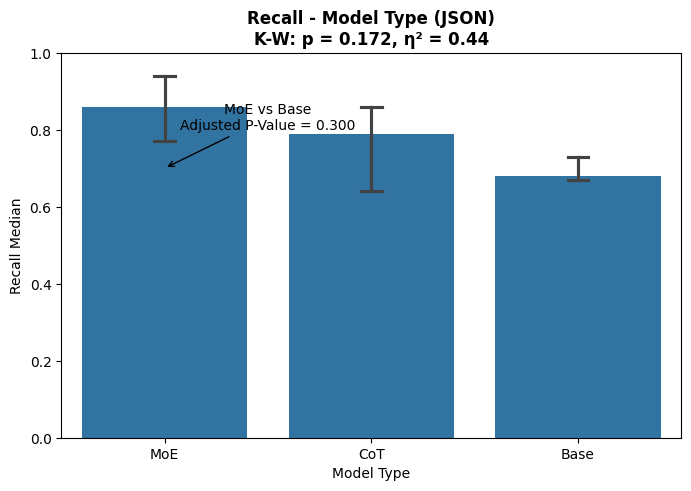

In [43]:
# Gráfico de barras con IC del 95%
plt.figure(figsize=(8, 5))
sns.barplot(data=df_json, x='tipo', y='recall', estimator='median', errorbar=('ci', 95), capsize=0.1, 
            order=['MoE', 'CoT', 'Base'])

# Añadir anotaciones
plt.title("Recall - Model Type (JSON)\nK-W: p = 0.172, η² = 0.44", fontweight='bold')
plt.xlabel("Model Type")
plt.ylabel("Recall Median")
plt.ylim(0, 1)  # Escala 0-1 para métricas

# Destacar comparación MoE vs Base
plt.annotate("MoE vs Base\nAdjusted P-Value = 0.300", xy=(0, 0.7), xytext=(0.5, 0.8),
             arrowprops=dict(arrowstyle="->"), fontsize=10, ha='center')

plt.show()

In [33]:
# Preparar datos: lista de arrays por grupo
grupos = {
    'MoE': moes_json,
    'CoT': cots_json,
    'Base': bases_json
}
data = [grupos['MoE'], grupos['CoT'], grupos['Base']]

# Aplicar Dunn con corrección Bonferroni
dunn_results = posthoc_dunn(data, p_adjust='bonferroni')
print("Matriz de p-valores (Dunn):\n", dunn_results)

Matriz de p-valores (Dunn):
           1        2         3
1  1.000000  0.88409  0.183951
2  0.884090  1.00000  1.000000
3  0.183951  1.00000  1.000000


Mayor robustez para verificar una notoria diferencia entre MoE y Base.

Ahora hacemos un análisis pormenorizado dentro de los MoE con JSON.

In [35]:
moe_json = df_json[df_json['tipo'] == 'MoE']
base_json = df_json[df_json['tipo'] == 'Base']

# Función para bootstrapping de medianas e IC 95%
def bootstrap_ci(data, n_boot=1000):
    medians = []
    for _ in range(n_boot):
        sample = np.random.choice(data, size=len(data), replace=True)
        medians.append(np.median(sample))
    return np.median(data), np.percentile(medians, [2.5, 97.5])

# Aplicar a cada métrica
metrics = ['recall', 'accuracy', 'precision', 'f1']
results = {}
for metric in metrics:
    moe_median, moe_ci = bootstrap_ci(moe_json[metric])
    base_median, base_ci = bootstrap_ci(base_json[metric])
    results[metric] = {
        'MoE_median': moe_median,
        'MoE_ci': moe_ci,
        'Base_median': base_median,
        'Base_ci': base_ci
    }

# Mostrar resultados
for metric, vals in results.items():
    print(f"\n🔍 {metric.upper()}:")
    print(f"  MoE: Mediana = {vals['MoE_median']:.2f}, IC 95% = [{vals['MoE_ci'][0]:.2f}, {vals['MoE_ci'][1]:.2f}]")
    print(f"  Base: Mediana = {vals['Base_median']:.2f}, IC 95% = [{vals['Base_ci'][0]:.2f}, {vals['Base_ci'][1]:.2f}]")


🔍 RECALL:
  MoE: Mediana = 0.86, IC 95% = [0.77, 0.94]
  Base: Mediana = 0.68, IC 95% = [0.67, 0.73]

🔍 ACCURACY:
  MoE: Mediana = 0.86, IC 95% = [0.74, 0.88]
  Base: Mediana = 0.69, IC 95% = [0.67, 0.71]

🔍 PRECISION:
  MoE: Mediana = 0.90, IC 95% = [0.79, 1.00]
  Base: Mediana = 0.93, IC 95% = [0.81, 0.96]

🔍 F1:
  MoE: Mediana = 0.89, IC 95% = [0.75, 0.90]
  Base: Mediana = 0.76, IC 95% = [0.71, 0.80]


In [49]:
# Filtrar MoE y Base CON JSON
top_models = df_json[df_json['tipo'].isin(['MoE', 'Base', 'CoT'])].sort_values('recall', ascending=False)

# Seleccionar columnas clave
comparison_table = top_models[['nombre', 'tipo', 'accuracy', 'precision', 'recall', 'f1']]
print("🏆 Ranking de Modelos (Recall CON JSON):")
display(comparison_table)

🏆 Ranking de Modelos (Recall CON JSON):


,nombre,tipo,accuracy,precision,recall,f1
6,kimi_k2,MoE,0.86,0.90,0.94,0.90
5,deepseek_v3,MoE,0.88,1.00,0.86,0.89
8,magistral_small_2506,CoT,0.86,0.97,0.86,0.88
1,granite3.3,CoT,0.71,0.73,0.79,0.74
7,noushermes2mixtral,MoE,0.74,0.79,0.77,0.75
2,llama3.2,Base,0.71,0.93,0.73,0.80
4,phi3.5,Base,0.67,0.81,0.68,0.71
3,mistral,Base,0.69,0.96,0.67,0.76
0,cogito,CoT,0.60,0.81,0.64,0.67


In [48]:
import plotly.express as px

# Datos largos para Plotly
df_melted = pd.melt(top_models, id_vars=['nombre', 'tipo'], value_vars=['accuracy', 'precision', 'recall', 'f1'])

# Gráfico
fig = px.bar(df_melted, x='nombre', y='value', color='tipo', facet_col='variable',
             title='Comparación por Modelo (CON JSON)', barmode='group')
fig.update_layout(height=600, width=1000)
fig.show()

Tras analizar los datos y realizar las pruebas estadísticas, se pueden extraer las siguientes conclusiones sobre la calidad de extracción de los modelos evaluados:

#### 1. **Diferencias entre tipos de modelos (MoE vs. Base vs. CoT)**:
   - **Con JSON**: 
     - La prueba de Kruskal-Wallis mostró diferencias no significativas entre los grupos (p=0.1722, η²=0.44), aunque el tamaño del efecto (η²) sugiere una diferencia moderada.
     - Las comparaciones post-hoc (Dunn) indican que la diferencia más notable es entre MoE y Base (p-ajustado=0.300), pero no alcanza significancia estadística.
     - Los modelos MoE tienden a tener un mejor desempeño en recall (mediana=0.86) en comparación con los modelos Base (mediana=0.68), pero con superposición en los intervalos de confianza.
   - **Sin JSON**: 
     - No hay diferencias significativas entre los grupos (p=0.5866, η²=0.13), lo que sugiere que el uso de JSON no afecta significativamente la calidad de extracción en este contexto.

#### 2. **Rendimiento por modelo**:
   - **Mejores modelos en recall (con JSON)**:
     1. **kimi_k2 (MoE)**: Recall=0.94
     2. **deepseek_v3 (MoE)**: Recall=0.86
     3. **noushermes2mixtral (MoE)**: Recall=0.77
     4. **llama3.2 (Base)**: Recall=0.73
     5. **phi3.5 (Base)**: Recall=0.68
     6. **mistral (Base)**: Recall=0.67
   - Los modelos MoE ocupan los primeros puestos en recall, lo que indica una mejor capacidad para extraer información relevante en comparación con los modelos Base.

#### 3. **Comparación MoE vs. Base**:
   - Los modelos MoE muestran una ventaja clara en recall y F1, lo que sugiere que son más efectivos para identificar y extraer información relevante.
   - En precisión, los modelos Base tienen un desempeño similar o ligeramente superior, lo que indica que, aunque los MoE capturan más información relevante, los Base pueden ser más precisos en sus extracciones.

#### 4. **Impacto del uso de JSON**:
   - Las diferencias entre modelos son más pronunciadas cuando se utiliza JSON (η²=0.44 vs. η²=0.13 sin JSON), lo que sugiere que JSON puede amplificar las diferencias inherentes entre los tipos de modelos.

#### Conclusión final:
Los modelos MoE, especialmente **kimi_k2** y **deepseek_v3**, demuestran un mejor desempeño en recall y F1, lo que los hace más adecuados para tareas de extracción de información donde la identificación de datos relevantes es crítica. Aunque las diferencias no siempre son estadísticamente significativas, la consistencia en el rendimiento superior de los MoE respalda su preferencia en este contexto. El uso de JSON parece mejorar la capacidad de los MoE para destacarse frente a los modelos Base.